# License

    Jupyter notebook for accessing CUDA
    Copyright (C) 2018 Andre.Brodtkorb@ifi.uio.no

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>.

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

#Import packages we need
import numpy as np
import pycuda.compiler as cuda_compiler
from pycuda.gpuarray import GPUArray
import pycuda.driver as cuda_driver

from matplotlib import pyplot as plt

In [2]:
#Initialize CUDA - must be first call to CUDA!
cuda_driver.init()

In [3]:
#Create CUDA context
cuda_device = cuda_driver.Device(0)
print("Using '{:s}'".format(cuda_device.name()))
print(" => compute capability: {:s}".format(str(cuda_device.compute_capability())))
context = cuda_device.make_context()
free, total = cuda_driver.mem_get_info()
print(" => memory: {:d} / {:d} MB available".format(int(free/(1024*1024)), int(total/(1024*1024))))

Using 'Tesla K80'
 => compute capability: (3, 7)
 => memory: 11370 / 11441 MB available


In [4]:
cuda_kernel = """
__global__ void addKernel(float* c, float* a, float* b) {
    unsigned int i = blockIdx.x*blockDim.x + threadIdx.x;
    c[i] = a[i] + b[i];
}
"""
module = cuda_compiler.SourceModule(cuda_kernel)
kernel = module.get_function("addKernel");

In [5]:
#Size of our test
n = 50

#Create test input / output data
a = np.random.rand(n).astype(np.float32)
b = np.random.rand(n).astype(np.float32)
c = np.empty_like(a)

#Upload data to the device
a_g = GPUArray(a.shape, np.float32)
b_g = GPUArray(b.shape, np.float32)
a_g.set(a)
b_g.set(b)

#Allocate output data
c_g = GPUArray(c.shape, np.float32)

#Execute program on device
kernel(c_g, a_g, b_g, block=(n, 1, 1), grid=(1,1))

#Copy data from device to host
c_g.get(c)

array([1.2390835 , 1.7316462 , 0.2094824 , 0.992673  , 0.8471042 ,
       1.3583531 , 0.3742493 , 1.0234925 , 0.8686055 , 0.99376285,
       0.6788165 , 0.27835107, 1.0649819 , 0.81114316, 1.1556437 ,
       0.49063978, 0.88705045, 1.5727118 , 1.4581225 , 1.302871  ,
       0.87387985, 1.4459764 , 1.7437735 , 1.8215308 , 0.13281313,
       0.43110964, 0.7469964 , 1.5784448 , 1.0343983 , 0.8955166 ,
       1.0170916 , 1.0971335 , 0.39845616, 0.8001771 , 0.042189  ,
       0.48976988, 0.62448823, 0.7748919 , 1.475509  , 0.39548764,
       1.0381508 , 1.200038  , 0.6677542 , 1.4069805 , 0.680382  ,
       1.4314566 , 1.5966337 , 0.77739644, 1.0071863 , 1.6097723 ],
      dtype=float32)

In [6]:
#Compute reference using Numpy
c_ref = a + b

#Print result
print("C   = ", c)
print("Ref = ", c_ref)
print("Sad = ", np.sum(np.abs(c - c_ref)))

C   =  [1.2390835  1.7316462  0.2094824  0.992673   0.8471042  1.3583531
 0.3742493  1.0234925  0.8686055  0.99376285 0.6788165  0.27835107
 1.0649819  0.81114316 1.1556437  0.49063978 0.88705045 1.5727118
 1.4581225  1.302871   0.87387985 1.4459764  1.7437735  1.8215308
 0.13281313 0.43110964 0.7469964  1.5784448  1.0343983  0.8955166
 1.0170916  1.0971335  0.39845616 0.8001771  0.042189   0.48976988
 0.62448823 0.7748919  1.475509   0.39548764 1.0381508  1.200038
 0.6677542  1.4069805  0.680382   1.4314566  1.5966337  0.77739644
 1.0071863  1.6097723 ]
Ref =  [1.2390835  1.7316462  0.2094824  0.992673   0.8471042  1.3583531
 0.3742493  1.0234925  0.8686055  0.99376285 0.6788165  0.27835107
 1.0649819  0.81114316 1.1556437  0.49063978 0.88705045 1.5727118
 1.4581225  1.302871   0.87387985 1.4459764  1.7437735  1.8215308
 0.13281313 0.43110964 0.7469964  1.5784448  1.0343983  0.8955166
 1.0170916  1.0971335  0.39845616 0.8001771  0.042189   0.48976988
 0.62448823 0.7748919  1.475509   

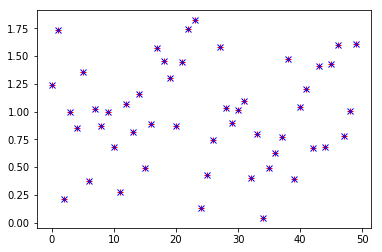

In [7]:
plt.figure()
plt.plot(c, '+r')
plt.plot(c_ref, 'xb')